# Общее конфигурирование

In [1]:
from agentslab.utils.device import resolve_device
from pathlib import Path
from agentslab.utils.misc import GeneralConfigs

ENV_ID = "InvertedDoublePendulum-v4"
# ENV_ID = "CartPole-v1"
# ENV_ID = "InvertedPendulum-v5"
# ENV_ID = "Pendulum-v1"

genCfg = GeneralConfigs(
    root = Path('..').resolve(),
    algo_name= "PPO",
    env_id = ENV_ID,
    device = resolve_device("cuda"),
    seed = 42,
    deterministic = True
)

# Generate Paths, Set Seeds

In [2]:
from agentslab.utils.seeding import set_global_seed
from agentslab.utils.misc import generate_paths, restore_paths

set_global_seed(genCfg.seed, deterministic=genCfg.deterministic)

# pathCfg = generate_paths(genCfg.root, genCfg.algo_name, genCfg.env_name)
pathCfg = restore_paths(genCfg.root, "ppo_InvertedDoublePendulum_20250823_044122")

# Создание среды

In [4]:
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env
from torchrl.envs.utils import check_env_specs

env_cfg = GymEnvConfig(env_id=ENV_ID, 
                       render_mode=None, 
                       device=genCfg.device, 
                       seed=genCfg.seed)

env = make_gym_env(env_cfg)
check_env_specs(env)

# from agentslab.utils.specs import print_specs
# print_specs(env)

2025-08-24 03:55:45,984 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора и критика

In [5]:
from agentslab.modules.networks import MLPConfig, build_mlp
from agentslab.modules.policy import build_stochastic_actor, is_acts_discrete
from torchrl.modules import ValueOperator

# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
act_dim = env.action_spec.shape[-1]

# если действия непрерывные, то число выходов нейросети нужно удвоить:
coef = 1 if is_acts_discrete(env.action_spec) else 2
mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        out_dim = act_dim * coef,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)
actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)

mlp_cfg.out_dim = 1
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])
actor.to(genCfg.device), critic.to(genCfg.device)
obs_dim, act_dim

(11, 1)

# Конфигурирование PPO

In [6]:
from agentslab.runners.trainers import PPOConfigs

ppoCfg = PPOConfigs(
    actor = actor,
    critic = critic,
    gamma = 0.99,
    lmbda = 0.95,
    frames_per_batch = 1000,
    total_frames = 10_000,
    clip_epsilon = 0.2,
    entropy_eps = 1e-4,
    lr = 3e-4,
    critic_coeff = 1.0,
    loss_critic_type = "smooth_l1",
    max_grad_norm = 1.0,
    num_epochs = 10,
    sub_batch_size = 64,
    eval_every = 5,
)

# Loss Function

In [7]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

advantage_module = GAE(
    gamma=ppoCfg.gamma, lmbda=ppoCfg.lmbda, value_network=critic, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=ppoCfg.clip_epsilon,
    entropy_bonus=bool(ppoCfg.entropy_eps),
    entropy_coeff=ppoCfg.entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=ppoCfg.critic_coeff,
    loss_critic_type=ppoCfg.loss_critic_type,
)

optim = torch.optim.Adam(loss_module.parameters(), ppoCfg.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=ppoCfg.total_frames // ppoCfg.frames_per_batch, 
    eta_min=0.0
)

# Collector

In [8]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

collector = SyncDataCollector(
    create_env_fn=env,
    policy=actor,
    frames_per_batch=ppoCfg.frames_per_batch,
    total_frames=ppoCfg.total_frames,
    split_trajs=False,
    device=genCfg.device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=ppoCfg.frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Checkpointers

In [12]:
from agentslab.utils.checkpointers import CheckpointManager

statefuls = {
    "policy": actor,                # nn.Module
    "optimizer": optim,             # torch.optim.Optimizer
    "scheduler": scheduler,         # lr scheduler
    "replay": replay_buffer,        # TorchRL ReplayBuffer (если используете)
}

chkptr = CheckpointManager(
    ckpt_dir=pathCfg.ckpt_dir,               # .../runs/<run_name>/checkpoints
    statefuls=statefuls,
    meta={"algo": genCfg.algo_name, "env": genCfg.env_id},
    best_metric_key="return_mean",    # по какой метрике выбирать best
    mode="max",                            # "min" для ошибок/лоссов
    max_to_keep=5,
)

# Loggers

In [19]:
from agentslab.utils.loggers import CSVLogger, TBLogger

csv_logger_train = CSVLogger(pathCfg.csv_train)
csv_logger_eval = CSVLogger(pathCfg.csv_eval)
tb_logger_train = TBLogger(pathCfg.tb_train)
tb_logger_eval = TBLogger(pathCfg.tb_eval)

# Training Loop

In [20]:
from agentslab.utils.misc import progress_bar
from agentslab.runners.evals import eval_policy

log_dict = dict()
passed_frames = 0

with progress_bar(ppoCfg.total_frames, desc="PPO") as pbar:
    # --------------------------------------------------------------
    # Итерируемся по коллекторам, пока не наберём нужное число шагов
    for i, tensordict_data in enumerate(collector):
        # Учимся на партии данных
        for _ in range(ppoCfg.num_epochs):
            # Advantage для PPO пересчитываем на каждом проходе
            advantage_module(tensordict_data)
            data_view = tensordict_data.reshape(-1)
            replay_buffer.extend(data_view.cpu())
            for _ in range(ppoCfg.frames_per_batch // ppoCfg.sub_batch_size):
                subdata = replay_buffer.sample(ppoCfg.sub_batch_size)
                loss_vals = loss_module(subdata.to(genCfg.device))
                loss_value = (
                      loss_vals["loss_objective"] 
                    + loss_vals["loss_critic"] 
                    + loss_vals["loss_entropy"]
                )
                # Оптимизация
                loss_value.backward()
                torch.nn.utils.clip_grad_norm_(loss_module.parameters(), ppoCfg.max_grad_norm)
                optim.step()
                optim.zero_grad()
        scheduler.step()            # Шаг LR-планировщика

        # --------------------------------------------------------------

        # Извлекаем метрики
        batch_frames = int(tensordict_data.get(("next", "reward")).numel())
        passed_frames = min(passed_frames + batch_frames, ppoCfg.total_frames)
        log_dict['step'] = passed_frames
        log_dict["reward"] = tensordict_data["next", "reward"].mean().item()
        log_dict["step_count"] = tensordict_data["step_count"].max().item()
        log_dict["lr"] = optim.param_groups[0]["lr"]
        
        # Логгируем метрики
        csv_logger_train.log(log_dict)                          # CSV
        tb_logger_train.log(log_dict, step=log_dict['step'])    # TensorBoard

        # Обновляем описание прогресс-бара
        pbar.set_postfix(
            {"avg_reward": f"{log_dict["reward"]: .4f}",
             "max_step": int(log_dict["step_count"]),
             "lr": f"{log_dict["lr"]: .4e}"},
            refresh=False
        )

        # корректное число фреймов в партии

        if batch_frames > 0:
            remaining = pbar.total - pbar.n
            pbar.update(min(batch_frames, remaining))

        # -----------------------------------------------------------
        # Оценка после каждых eval_every партий
        if (i + 1) % ppoCfg.eval_every == 0:
            eval_results = eval_policy(env, actor, episodes=5, progress=False)
            # pbar.write не ломает отрисовку прогресс-бара
            pbar.write(
                f'eval: avg reward = {eval_results["return_mean"]}, '
                f'max episode lengh = {eval_results["max_episode_lengh"]}'
            )
            eval_results["step"] = log_dict['step']
            csv_logger_eval.log(eval_results)                          # CSV
            tb_logger_eval.log(eval_results, step=log_dict['step'])    # TensorBoard
            chkptr.save(step=log_dict['step'], metrics=eval_results, make_step_snapshot=True)
        

PPO:   0%|          | 0.00/10.0k [00:00<?, ?frames/s]

eval: avg reward = 153.98037719726562, max episode lengh = 18
eval: avg reward = 202.35574035644532, max episode lengh = 26


# Graphs

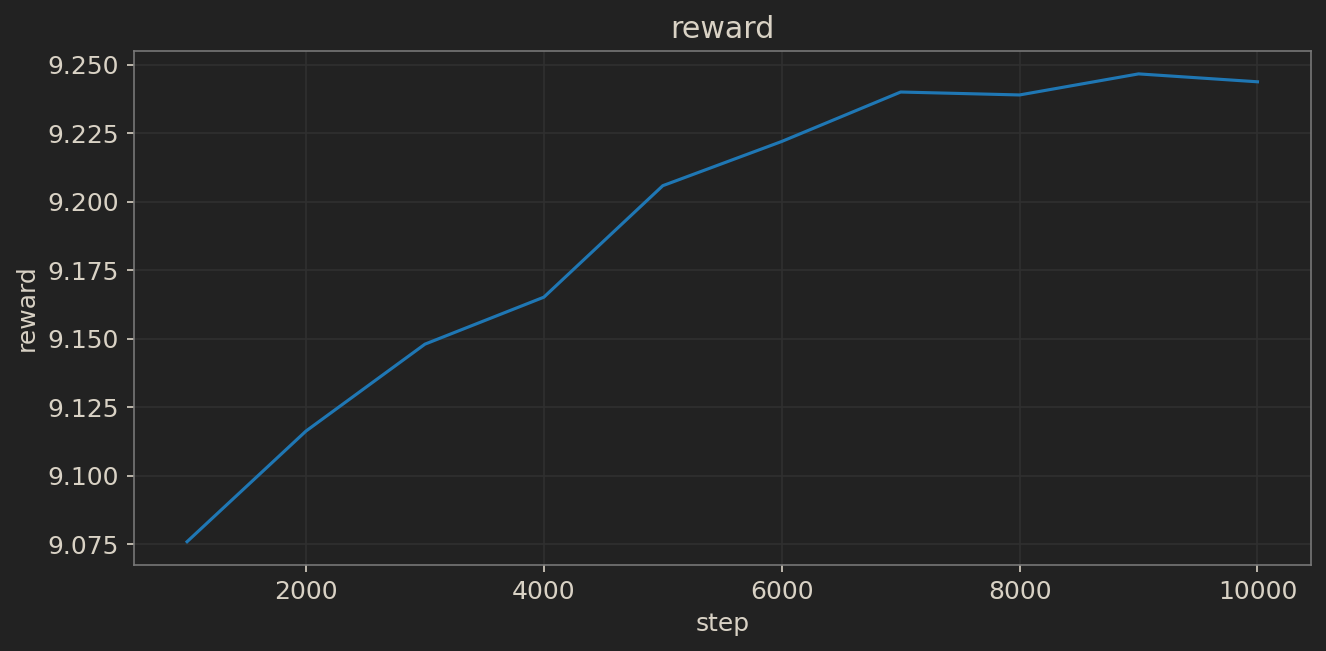

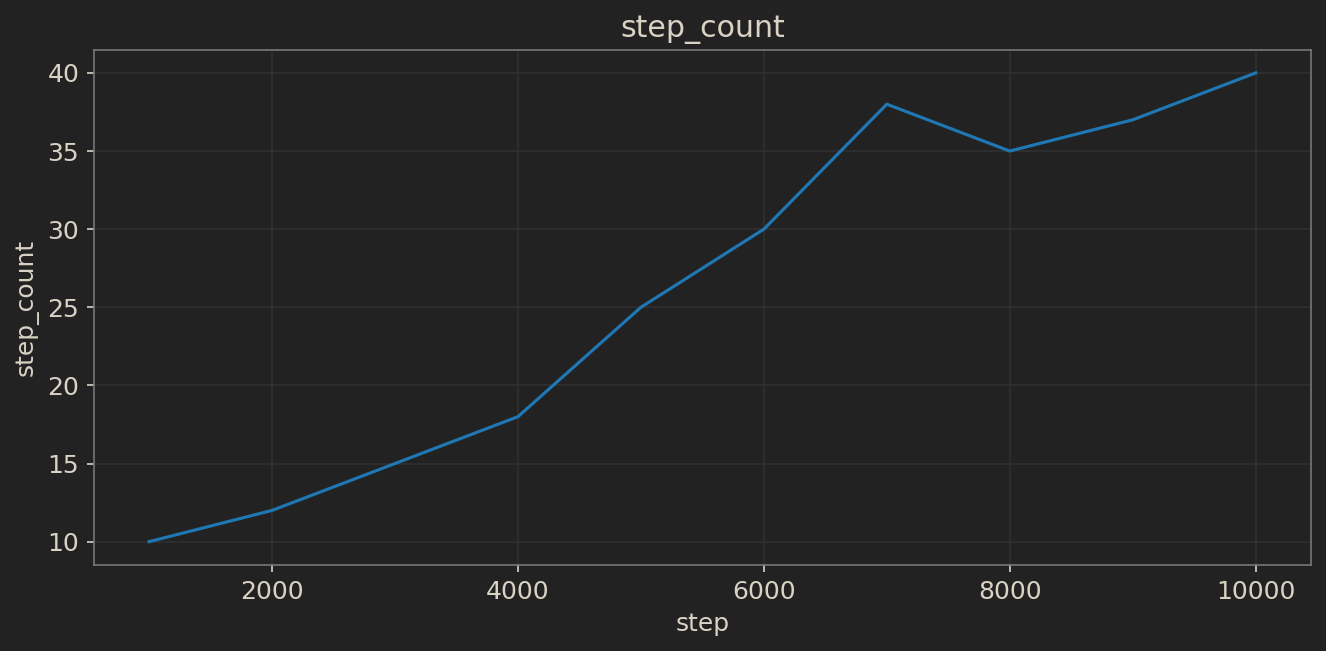

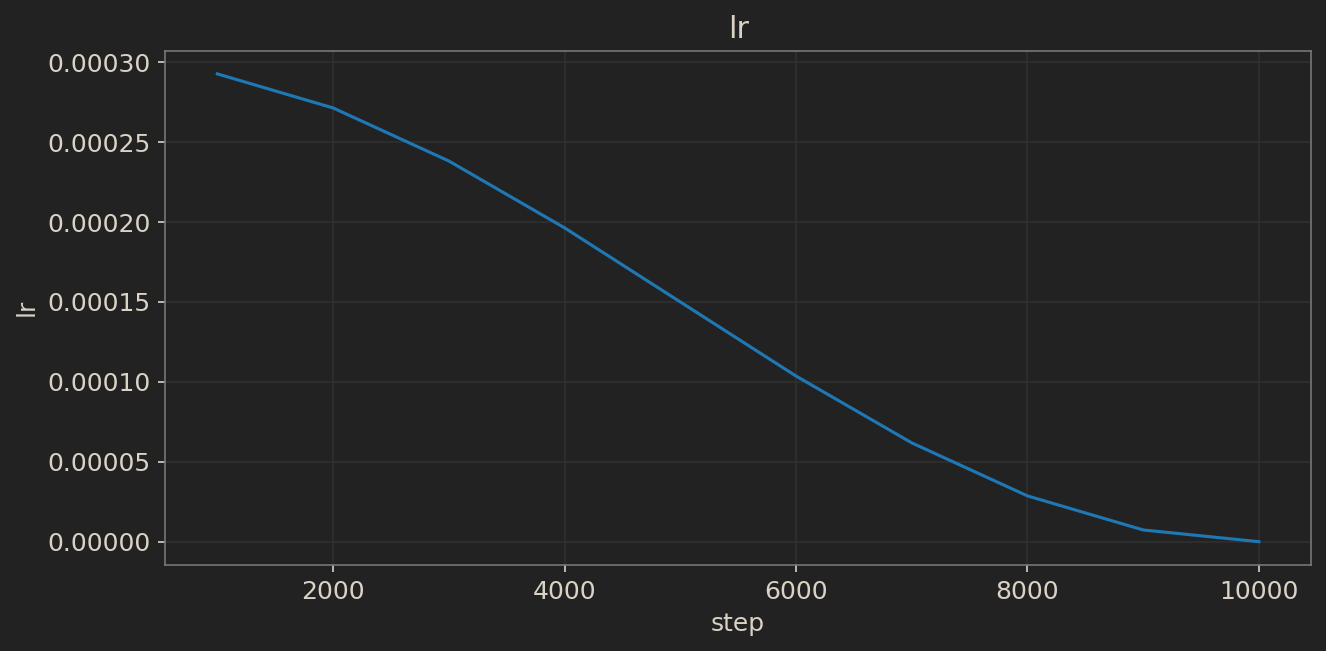

In [21]:
# Чтение последнего train.csv и построение графиков по каждой метрике
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ordevoir-dark")

csv_path = pathCfg.csv_train  # объект paths из вашего кода (RunPaths.csv_train)

# Проверим наличие файла
if not csv_path.exists():
    raise FileNotFoundError(f"train.csv не найден по пути: {csv_path}")

# Читаем CSV (без агрессивных эвристик типов, чтобы избежать предупреждений)
df = pd.read_csv(csv_path, low_memory=False)

# Определим ось X: предпочитаем 'step', затем 'global_step', 'iteration', 'epoch'
x_candidates = [c for c in ["step", "global_step", "iteration", "epoch"] if c in df.columns]
x_col = x_candidates[0] if x_candidates else None

# Выбираем числовые столбцы, исключая ось X
num_cols = df.select_dtypes(include="number").columns.tolist()
if x_col in num_cols:
    num_cols.remove(x_col)

if not num_cols:
    raise ValueError(
        "В train.csv не найдено числовых метрик для построения графиков."
    )

# Строим отдельную диаграмму для каждой метрики
for col in num_cols:
    plt.figure(figsize=(9, 4.5))
    if x_col is not None:
        plt.plot(df[x_col], df[col])
        plt.xlabel(x_col)
    else:
        plt.plot(range(len(df)), df[col])
        plt.xlabel("index")
    plt.ylabel(col)
    plt.title(f"{col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Evaluating

In [15]:
from agentslab.runners.evals import eval_policy

eval_policy(env, actor, episodes=10)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
chkptr.load("best", strict=False, map_location=genCfg.device)

In [26]:
def play(env, policy):
    policy.eval()
    obs, _ = env.reset()
    total = 0.0
    with torch.no_grad():
        for _ in range(200):
            s = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            a = policy(s).argmax(1).item()
            obs, r, term, trunc, _ = env.step(a)
            total += r
            if term or trunc:
                break
    env.close()
    return total

In [34]:
import torch
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env

# 1) Собираем среду в human-режиме (откроется окно с рендером)
cfg = GymEnvConfig(
    env_id="InvertedDoublePendulum-v4",  # можно поменять на любой другой
    render_mode="human",
    norm_obs=True,
    init_norm_iter=1000,
    max_steps=1000,          # ограничим длину эпизода
    device=genCfg.device,            # выставьте под вашу policy ("cuda" при необходимости)
    seed=0,
)
env = make_gym_env(cfg)

c:\Users\ordevoir\miniconda3\envs\marl\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


In [19]:
# --- Jupyter cell: запускаем эпизоды, действия выбирает policy, без автосимуляции ---

import torch
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env

# 1) Создаём среду БЕЗ автосбора статистик нормализации (чтобы не было скрытых прогонов)
cfg = GymEnvConfig(
    env_id="InvertedDoublePendulum-v4",
    render_mode="human",   # окно рендера
    norm_obs=False,        # <- выключаем нормировку, чтобы ничего не крутилось заранее
    init_norm_iter=0,      # <- на всякий случай
    max_steps=1000,
    device="cuda",
    seed=0,
)

env = make_gym_env(cfg)

actor.eval()

def _is_done(td):
    # Поддержка разных ключей завершения
    if "done" in td.keys():
        return bool(td["done"].item())
    term = bool(td.get("terminated", torch.tensor(False)).item())
    trunc = bool(td.get("truncated", torch.tensor(False)).item())
    return term or trunc

# 3) Основной цикл
num_episodes = 3
for ep in range(num_episodes):
    td = env.reset()
    ep_return = 0.0

    for _ in range(cfg.max_steps or 10_000):
        with torch.no_grad():
            td = actor(td)   # policy пишет действие в td["action"]
        td = env.step(td)     # среда делает шаг, формирует новое td

        # Явный рендер (в human-режиме откроется/обновится окно)
        try:
            env.render()
        except Exception:
            pass

        ep_return += float(td.get("reward", torch.tensor(0.0)).item())
        if _is_done(td):
            break

    print(f"Episode {ep+1}/{num_episodes} return: {ep_return:.2f}")

# env.close()  # при необходимости


Episode 1/3 return: 0.00


c:\Users\ordevoir\miniconda3\envs\marl\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


Episode 2/3 return: 0.00
Episode 3/3 return: 0.00


In [18]:
# --- Jupyter cell: run a TorchRL Gym env visually with an existing policy ---

actor.eval()
def _is_done(td):
    # В разных версиях TorchRL/ Gymnasium можно встретить 'done', либо пару 'terminated'/'truncated'
    if "done" in td.keys():
        return bool(td["done"].item())
    term = bool(td.get("terminated", torch.tensor(False)).item())
    trunc = bool(td.get("truncated", torch.tensor(False)).item())
    return term or trunc

num_episodes = 1
for ep in range(num_episodes):
    td = env.reset()
    ep_return = 0.0

    # Шаги эпизода
    for _ in range(10_000):
        with torch.no_grad():
            # policy ожидает tensordict со входом "observation" и кладёт действие в "action"
            td = actor(td)
        td = env.step(td)    # среда читает td["action"] и возвращает след. состояние/награду/флаги

        # Рендер (для надёжности вызываем явно; в human-режиме окно будет обновляться)
        try:
            env.render()
        except Exception:
            pass

        # Суммируем награду
        r = float(td.get("reward", torch.tensor(0.0)).item())
        ep_return += r

        if _is_done(td):
            break

        # Подготовка входа для следующего шага: в td уже лежит новое "observation"
        # (В TorchRL TransformedEnv это обычно уже сделано; оставлено как пояснение.)

    print(f"Episode {ep+1}/{num_episodes} return: {ep_return:.2f}")

# По желанию:
# env.close()


KeyboardInterrupt: 